### Taiwan credit card data set .
##### Jan 2019

A note of appreciation to the original providers of the data(1) and UCI(5) for making the data set available. The data contains a mixture of variable types but the target variable of interest is binary and flags if somebody defaulted or not on a credit card in Taiwan in 2005.

##### Preface
Of interest was what factors present in the data might help explain what was causing people to default. At the outset there seemed to be a lot of valuable attributes missing that would help in predicting if somebody was about to default. Rather than undertake much if any feature engineering I was more interested in working with the existing data and applying a few different models that may help in pointing to any interesting features in the existing data. I worked with Extremely Randomized Trees and a more traditional Probit model often favoured by econometricians.

I decided to work with the Extremely Randomized Trees(ET) algorithm(2) given that the paper(4) below managed to achieve accuracy levels above 90% albeit with significant feature engineering and an expansion of the original data. 

The three main hyperparameters of the ET model were set as follows,(i)max number of attributes/features at square root(n_features),(ii) minimum sample size of a split to 2 records and (iii) number of estimators at 100. For the ET algorithm data was passed as is without any transformation. I wanted to check for stability in the features selected by the algorithm to split the data. I ran the model 500 times and aggregrated the frequency of each freature in the top ten most important attributes. See table below on feature occurrence. 

The Probit model is often favoured by econometricians versus the logit model. There is definite multicollinearity among many of the independent variables(3) but the reason for using the model was to see which variables were showing up as significant(95% and/or 99%). 

##### Result 
With replacement the ET model scored around 89% versus baseline of 78%. As much as the algorithm is more resilient than decision trees and random forests to non-relevant attributes the decision was made to cap max features to the square root of total features. 

Both ET and Probit models picked up Education, Marital status and Sex as influential factors in dictating if a borrower might default. One is splitting data on Gini importance and looking for impurity in the results the other is using mamimum likelihood estimation to help assess the probability of a default given each attribute. Interestingly the Probit model is picking up a recency effect in that the more behind is the borrower in their most recent payments and the less paid back to the lender in the most recent period the higher the probability the borrower will default. 

There is a need here to get more data on the borrower that would be helpful to a loan or credit officer in making a decision on whether to extend credit or not to a borrower and in predicting of somebody might default. 


  
##### References
1. Yeh, I-Cheng, and Che-hui Lien(2009. The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications 36.2 (2009): 2473-2480.J.Clerk Maxwell, A Treatise on Electricity and Magnetism, 3rd ed., vol. 2.Oxford: Clarendon, 1892

2. Geurts P, Ernst,D · Wehenkel, L (2006), Extremely randomized trees, Department of Electrical Engineering and Computer Science, University of Liege,

3. O’Brien, R.M. (2007), A Caution Regarding Rules of Thumb for Variance Inflation Factors,Quality & Quantity (2007) 41:673–690

4. Islam, S.R. , Eberle W., Ghafoor S.K. (2018): Credit Default Mining Using Combined Machine Learning and Heuristic Approach, ICDATA, 2018

5. UCI: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

 

### Breakdown of the attributes and target variables in the data set.  

### Target variable:
This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. The class split is aprox 22% vs 78% in the data.

### Explanatory variables/Predictors(23) :
1. LIMIT BAL: Amount of the given credit (NT dollar).It includes both the individual consumer credit and his/her                family (supplementary) credit. 
2. SEX: Gender (1 = male; 2 = female). 
3. EDUCATION (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
4. MARRIED (1 = married; 2 = single; 3 = others). 
5. AGE=(year). 
6. PAY_0= the repayment status in September, 2005; 
7. PAY_2= the repayment status in August, 2005;
8. PAY_3= the repayment status in July, 2005.
9. PAY_4= the repayment status in June, 2005
10. PAY-5= the repayment status in May, 2005
11. PAY_6= the  repayment status in April, 2005
12. BILL_AMT1= amount of bill statement in September, 2005 
13. BILL_AMT2= amount of bill statement in August, 2005 
14. BILL_AMT3= amount of bill statement in July, 2005.
15. BILL_AMT4= amount of bill statement in June, 2005.
16. BILL_AMT5= amount of bill statement in May, 2005
17. BILL_AMT6= amount of bill statement in April, 2005. 
18. PAY_AMT1= amount paid in September, 2005
19. PAY_AMT2= amount paid in August, 2005 
20. PAY_AMT3=amount paid in July, 2005
21. PAY_AMT4=amount paid in June, 2005
22. PAY_AMT5=amount paid in May, 2005
23. PAY_AMT6= amount paid in April, 2005. 

In [1]:
#Pandas
import pandas as pd
from pandas import DataFrame

#Numpy
import numpy as np

#Plots
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns

#SK Learn 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from sklearn import ensemble
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score

#Statsmodels
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
 


#Empty lists used to collect ET accuracy,F1 scores and which attributes were used to split data.
accuracy=[] 
features=[]
f1_sc=[]
 
#Functions needed for experiment.            
 
#Function to call the model,collect scores and collect important attributes. 
def extremely_random_trees(df,runs):
    for i in range(runs):
        #Define X matrix and Y.23 attributes in X matrix. 
        Y= df['default payment next month'] 
        X= df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
           'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
           'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
           'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]]
        #Binarize Y target class and define labels for majority and minority classes
        training_majority = df[df['default payment next month']==0]
        training_minority = df[df['default payment next month']==1] 
        #Resample with replacement from the minority class of defaulting 
        #obligors, cap class split as is 78%/22%(defaultor sample size n=6639) 
        training_minority_upsampled = resample(training_minority, 
                                 replace=True,      
                                 n_samples=6636,     
                                 random_state=None)   
        #Combine majority class with resampled minority class.
        df_upsampled = pd.concat([training_majority, training_minority_upsampled]) 
        Y1 = df_upsampled['default payment next month']
        X1 = df_upsampled[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
           'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
           'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
           'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]]    
        #Split data,80/20 Train/test. 
        X_train, X_test , y_train  , y_test   = train_test_split(X1, Y1, test_size=0.20,random_state=None) 
        ##Define model and collect scores(accuracy and F1)
        et =  ExtraTreesClassifier(class_weight='balanced',n_estimators=100,max_features='auto')                          
        et.fit(X_train,y_train)
        s=et.score(X_test,y_test)
        accuracy.append(s)        
        #F1 scores         
        pred= et.predict((X_test))        
        pred_round_1 = np.round(pred, decimals=0,out=None) 
        f1 = f1_score(y_test, pred_round_1,average='binary')                
        f1_sc.append(f1)          
        #Select top ten attributes(Gini importance levels) that were used to split the data
        importances = et.feature_importances_
        #Focus on top ten featues.
        indices = np.argsort(importances)[0:10]         
        for f in range(10):          
            x=(indices[f]+1)          
            features.append(x)
            
#Function to extract how often features were selected into the top ten by the model                  
def et_feature_occurrence(self):         
    feature_occurrence=pd.Series(self).value_counts()
    occurrences=feature_occurrence.rename(index={1: 'LIMIT_BAL', 2: 'SEX',3: 'EDUCATION',
           4: 'MARRIAGE',5:'AGE',6: 'PAY_0',7: 'PAY_2',8:'PAY_3',9: 'PAY_4',10: 'PAY_5',
           11: 'PAY_6',12: 'BILL_AMT1',13: 'BILL_AMT2', 14:'BILL_AMT3',15: 'BILL_AMT4',
           16: 'BILL_AMT5',17: 'BILL_AMT6',18: 'PAY_AMT1',19:'PAY_AMT2',20: 'PAY_AMT3',
           21: 'PAY_AMT4',22: 'PAY_AMT5',23: 'PAY_AMT6'})
    occurrences.index.rename('Features',inplace=True)
    occurrences_df= occurrences.to_frame('Feature Occurrence(500 runs)')
    print('Frequency of each attribute in top ten most important features')    
    return occurrences_df
         
#Plot accuracy and f1 scores
def plot_et_scores(accuracy,f1_score):        
    sns.distplot(accuracy, hist=False, label = "model accurancy score")
    sns.distplot(f1_score, hist=False, label = "model f1 score")
    plt.ylabel('frequency')
    plt.xlabel('score')
    plt.legend()
    plt.show() 
    model_mean_accuracy= np.mean(accuracy)
    model_std_accuracy=np.std(accuracy)
    model_mean_f1=np.mean(f1_score)
    model_std_f1=np.std(f1_score)
    ci_95_accuracy= model_std_accuracy*2
    ci_95_f1= model_std_f1*2
    print('Extra Trees mean accuracy and mean f1 scores : %f, %f' % (model_mean_accuracy,model_mean_f1))
    print('Extra Trees confidence interval(95pc) around mean accuracy and mean f1 scores(+/-): %f,%f' % (ci_95_accuracy,ci_95_f1)) 
    
#Function for Probit model, will return summary statistics for the model and produce 
#a VIF check for multicollinearity.   
def probit(df):
    Y1 = df['default payment next month']
    X1 = df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
           'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
           'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
           'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]  
    X2 = sm.add_constant(X1) 
    #Split data
    X_train, X_test, y_train, y_test = train_test_split(X2, Y1, test_size=0.2, random_state=42)
    #Fit model on training data
    model = sm.Probit(y_train, X_train).fit(disp=True, warn_convergence=True,maxiter=10)  
    #Check for Multicollinearity,VIF's.  
    series_1 = DataFrame(X_train)
    vif = [statsmodels.stats.outliers_influence.variance_inflation_factor(series_1.values, i) for i in range(series_1.shape[1])]
    print ('Variance inflation factors')  
    print (vif)                                
    #print model statistics     
    print (model.summary())

In [2]:
#Read in data
df = pd.read_excel('credit card clients.xls',header=1,index_col='ID')

In [3]:
#Feed in data and define the number of runs for the ET model.
extremely_random_trees(df,500) 

In [4]:
#Check each attribute's occurrence in top ten most important(Gini importance) attributes used to split data.
et_feature_occurrence(features) 

Frequency of each attribute in top ten most important features


,Feature Occurrence(500 runs)
Features,
PAY_6,500
EDUCATION,500
PAY_5,500
SEX,500
MARRIAGE,500
PAY_4,499
PAY_AMT4,497
PAY_AMT5,457
PAY_AMT3,431


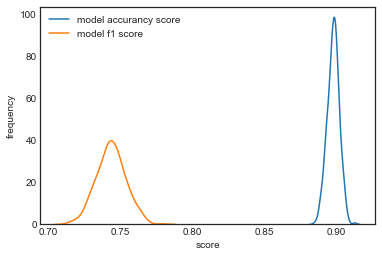

Extra Trees mean accuracy and mean f1 scores : 0.898042, 0.743686
Extra Trees confidence interval(95pc) around mean accuracy and mean f1 scores(+/-): 0.008304,0.020267


In [7]:
#Plot accuracy and F1 scores.
plot_et_scores(accuracy,f1_sc)

In [6]:
#Run Probit model on attributes as is and see what p-values are for each coefficient of the 
#predictor matrix(independent variables). Many of the independent variables have VIF's well
#above 1. I am only looking at p-values here although the coefficient signs are interesting.
#I am not interested in Psuedo R2 in this model.Only running model on training set.
probit(df)

Optimization terminated successfully.
         Current function value: 0.468477
         Iterations 6
Variance inflation factors
[63.87736315370678, 1.5620852429899288, 1.0247882821477197, 1.1250144563942508, 1.2298966494612238, 1.2764843615958255, 1.9323877128755071, 3.195180450447045, 3.6701214358332415, 4.284767203920089, 4.697350744686788, 3.2182326875426637, 14.02256210128634, 26.09161457495408, 21.629017872913966, 19.611985186300164, 25.04859455537672, 15.31247450047156, 1.7467235423537435, 2.389074114912927, 1.8319882573662871, 1.6757302505836034, 1.710674982173906, 1.1644988098041738]
                              Probit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                24000
Model:                                 Probit   Df Residuals:                    23976
Method:                                   MLE   Df Model:                           23
Date:                        Wed, 09 Jan 2019   Pseu